<font size="10">Bistable Traveling Waves with PINNs</font>

<font size="4">This notebook employs a physics informed neural network (PINN) to demonstrate the existence of traveling wave solutions to the bistable reaction-diffusion equation:
$\partial_t u = \partial_x^2 u + u(1 - u)(u - a), \quad a \in (0,1), \quad u = u(x,t).$
</font>

<font size="4">Through a series of manipulations, traveling wave solutions to the above partial differential equation are equivalent to solving the (parameterized) boundary value problem:
$U U' + cU + \xi(1 - \xi)(\xi - a), \quad U(0) = U(1) = 0, \quad \xi \in [0,1],$
</font>

<font size="4">where
$U = U(\xi)$, $\xi = x - ct$ is the new independent variable and $c \in \mathbb{R}$ is the (unknown) speed of propagation.</font>


<font size="4">The neural network is trained so that it approximates the function
$\xi \mapsto U(\xi)$ for each $\xi \in [0,1]$. The wave speed parameter $c$ is considered as a trainable network parameter that is found through the training process.</font>

<font size="4">This code was written by Mohit Sahu and accompanies the work in Section 5.4 of the book <i>Data-Driven Methods for Dynamic Systems</i>. This script was adapted from the Tensorflow version by Jason J. Bramburger. We use PyTorch 2.3.0 to build the neural network.</font>

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from time import time
import numpy as np

In [3]:
dtype = torch.float32

# set constants
pi = torch.tensor(np.pi)

In [9]:
# Define residual of the ODE
def fun_r(c, x, u, u_x):
    a = 0.9
    return u*u_x + c*u + x*(1 - x)*(x - a)

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Set number of data points
N_r = 1000

# Set boundary
xmin = 0.
xmax = 1.
X_b = torch.tensor([[xmin], [xmax]], requires_grad=True).to(device)

# Set random seed for reproducible results
torch.manual_seed(0)

# Interior points
X_r = torch.rand((N_r,1), requires_grad=True) * (xmax-xmin) + xmin
X_r = X_r.to(device)

In [10]:
class NeuralNetwork(nn.Module):
    def __init__(self, num_hidden_layers=12, num_neurons_per_layer=20):
        super(NeuralNetwork, self).__init__()

        # Create variable for the wave speed
        self.c = nn.Parameter(torch.tensor(0.0, requires_grad=True))

        # Input is one-dimensional
        self.input_layer = nn.Linear(1, num_neurons_per_layer)

        # Activation function
        self.selu = nn.SELU()

        # Hidden layers
        self.hidden_layers = nn.ModuleList([
            nn.Linear(num_neurons_per_layer, num_neurons_per_layer)

            for _ in range(num_hidden_layers)
        ])

        # Output is one-dimensional
        self.output_layer = nn.Linear(num_neurons_per_layer, 1)

        self._initialize_weights()

    def _initialize_weights(self):
        for layer in self.hidden_layers:
            nn.init.xavier_normal_(layer.weight)

    def forward(self, x):
        x = self.selu(self.input_layer(x))
        for layer in self.hidden_layers:
            x = layer(x)
            x = self.selu(x)
        x = self.output_layer(x)
        return x

In [7]:
def compute_loss(model, X_r, X_b):
    X_r = X_r.detach().requires_grad_(True)
    # Determine residual
    u = model(X_r)

    # Compute gradient u_x
    u_x = torch.autograd.grad(u, X_r, grad_outputs=torch.ones_like(u), create_graph=True)[0]

    # Get wave speed variable
    c = model.c

    # Define loss
    loss = torch.mean(fun_r(c, X_r, u, u_x)**2)

    # Neumann boundary conditions in loss
    u0 = model(X_b)
    loss += torch.mean(u0**2)

    return loss

In [8]:
# Initialize model aka P(U)
model = NeuralNetwork()
model = model.to(device)

# Learning rate schedule
lr_schedule = [1e-3, 1e-4, 1e-5]
def get_lr(epoch):
    if epoch < 1000:
        return lr_schedule[0]
    elif epoch < 3000:
        return lr_schedule[1]
    else:
        return lr_schedule[2]

# Choose the optimizer
optimizer = optim.Adam(model.parameters(), lr=lr_schedule[0])

# Number of training epochs
N = 10000
hist = []

In [9]:
# Start timer
t0 = time()

for i in range(N+1):
    # Update learning rate
    for param_group in optimizer.param_groups:
        param_group["lr"] = get_lr(i)

    # Reset gradient of optimizer to 0
    optimizer.zero_grad()

    # Compute loss
    loss = compute_loss(model, X_r, X_b)
    loss.backward()

    # Perform gradient descent step
    optimizer.step()

    # Append current loss to hist
    hist.append(loss.item())

    # Output current loss after 50 iterates
    if i % 50 == 0:
        print('It {:05d}: loss = {:10.8e}'.format(i, loss.item()))

# Print computation time
print('\nComputation time: {} seconds'.format(time()-t0))

/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:825: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at ../aten/src/ATen/cuda/CublasHandlePool.cpp:135.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


It 00000: loss = 6.32752180e-01
It 00050: loss = 6.56306185e-03
It 00100: loss = 6.43149856e-03
It 00150: loss = 6.45451201e-03
It 00200: loss = 6.45221351e-03
It 00250: loss = 6.44957554e-03
It 00300: loss = 6.42957864e-03
It 00350: loss = 5.89509588e-03
It 00400: loss = 5.34633547e-03
It 00450: loss = 3.31421453e-03
It 00500: loss = 2.43256730e-03
It 00550: loss = 2.13805446e-03
It 00600: loss = 1.69081928e-03
It 00650: loss = 1.09720079e-03
It 00700: loss = 9.13659693e-04
It 00750: loss = 7.69130886e-04
It 00800: loss = 5.02715120e-04
It 00850: loss = 6.18134625e-04
It 00900: loss = 3.02819390e-04
It 00950: loss = 2.51428224e-04
It 01000: loss = 2.08381214e-04
It 01050: loss = 1.86441830e-04
It 01100: loss = 1.80621137e-04
It 01150: loss = 1.76228918e-04
It 01200: loss = 1.71489941e-04
It 01250: loss = 1.66192156e-04
It 01300: loss = 1.61652337e-04
It 01350: loss = 1.57397502e-04
It 01400: loss = 1.53582980e-04
It 01450: loss = 1.49894069e-04
It 01500: loss = 1.46673308e-04
It 01550

tensor(-0.5208)
tensor([[-3.4183e-05],
        [ 2.0406e-04]])


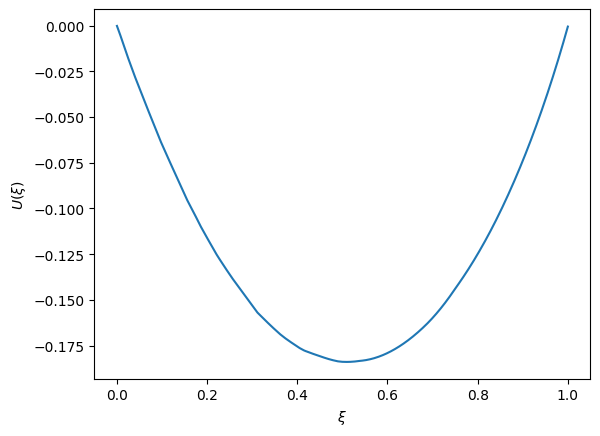

In [18]:
# View trained model specs
from matplotlib import pyplot as plt

# Predicted wave speed
print(model.c.cpu().detach())

# Determine predictions of u(x)
X = torch.tensor(np.linspace(xmin,xmax, 5000).reshape(-1,1), dtype=dtype).to(device)
upred = model(X)

# Plot results
plt.plot(X.cpu().detach(),upred.cpu().detach())
plt.xlabel(r'$\xi$')
plt.ylabel(r'$U(\xi)$')

# Check boundary conditions
u_b = model(model(X_b))
print(u_b.cpu().detach())

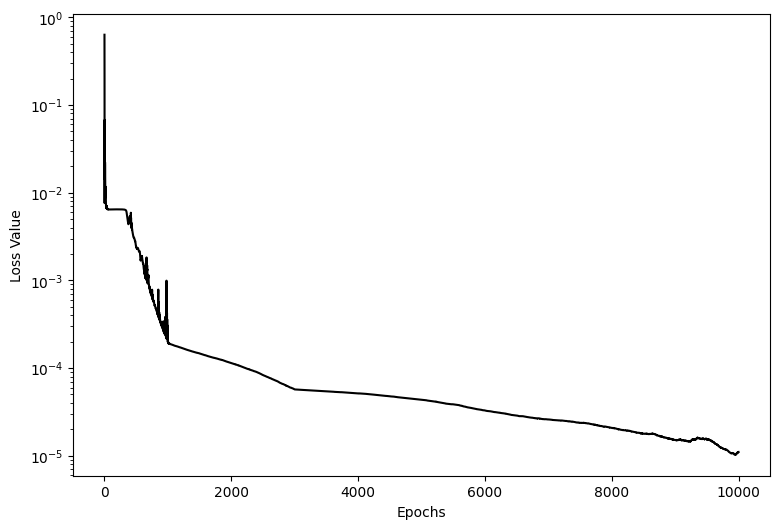

In [19]:
# View loss function values vs. number of epochs
fig = plt.figure(figsize=(9,6))
ax = fig.add_subplot(111)
ax.semilogy(range(len(hist)), hist,'k-')
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss Value');

In [ ]:
# Loading saved models
import tensorflow as tf

def loadModel(file_path, device=torch.device('cuda' if torch.cuda.is_available() else 'cpu'),num_hidden_layers=11):
    """To Load Tensorflow model and convert the model to pyTorch
    
        Note: This function will not work if the architecture of the model is different 
    """
    loaded_model = tf.keras.models.load_model(file_path, compile=False)
    loaded_weights = loaded_model.get_weights()
    pytorch_model = NeuralNetwork(num_hidden_layers=num_hidden_layers).to(device)

    # load the weights of the input layer
    pytorch_model.input_layer.weight = nn.Parameter(torch.tensor(loaded_weights[0].T).to(device))
    pytorch_model.input_layer.bias = nn.Parameter(torch.tensor(loaded_weights[1]).to(device))

    # load the weights of the hidden layer
    for i in range(1, num_hidden_layers+1):
        pytorch_model.hidden_layers[i-1].weight = nn.Parameter(torch.tensor(loaded_weights[2*i].T).to(device))
        pytorch_model.hidden_layers[i-1].bias = nn.Parameter(torch.tensor(loaded_weights[2*i+1]).to(device))

    pytorch_model.output_layer.weight = nn.Parameter(torch.tensor(loaded_weights[2*(num_hidden_layers+1)].T).to(device))
    pytorch_model.output_layer.bias = nn.Parameter(torch.tensor(loaded_weights[2*(num_hidden_layers+1)+1]).to(device))

    # now load the variables
    try:
        pytorch_model.c = nn.Parameter(torch.tensor(loaded_model.c.numpy()).to(device))
    except:
        pass

    return pytorch_model

In [49]:
model = loadModel("../traveling_wave_models/twave_a=0.9")

# Predicted wave speed
print(model.c.cpu().detach())

# Check boundary conditions
u_b = model(model(X_b))
print(u_b.cpu().detach())

tensor(0.5677)
tensor([[ 1.8378e-05],
        [-8.7474e-07]])


In [47]:
import os
file_path = os.listdir("../traveling_wave_models/")
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # to stop tensorflow from giving warnings

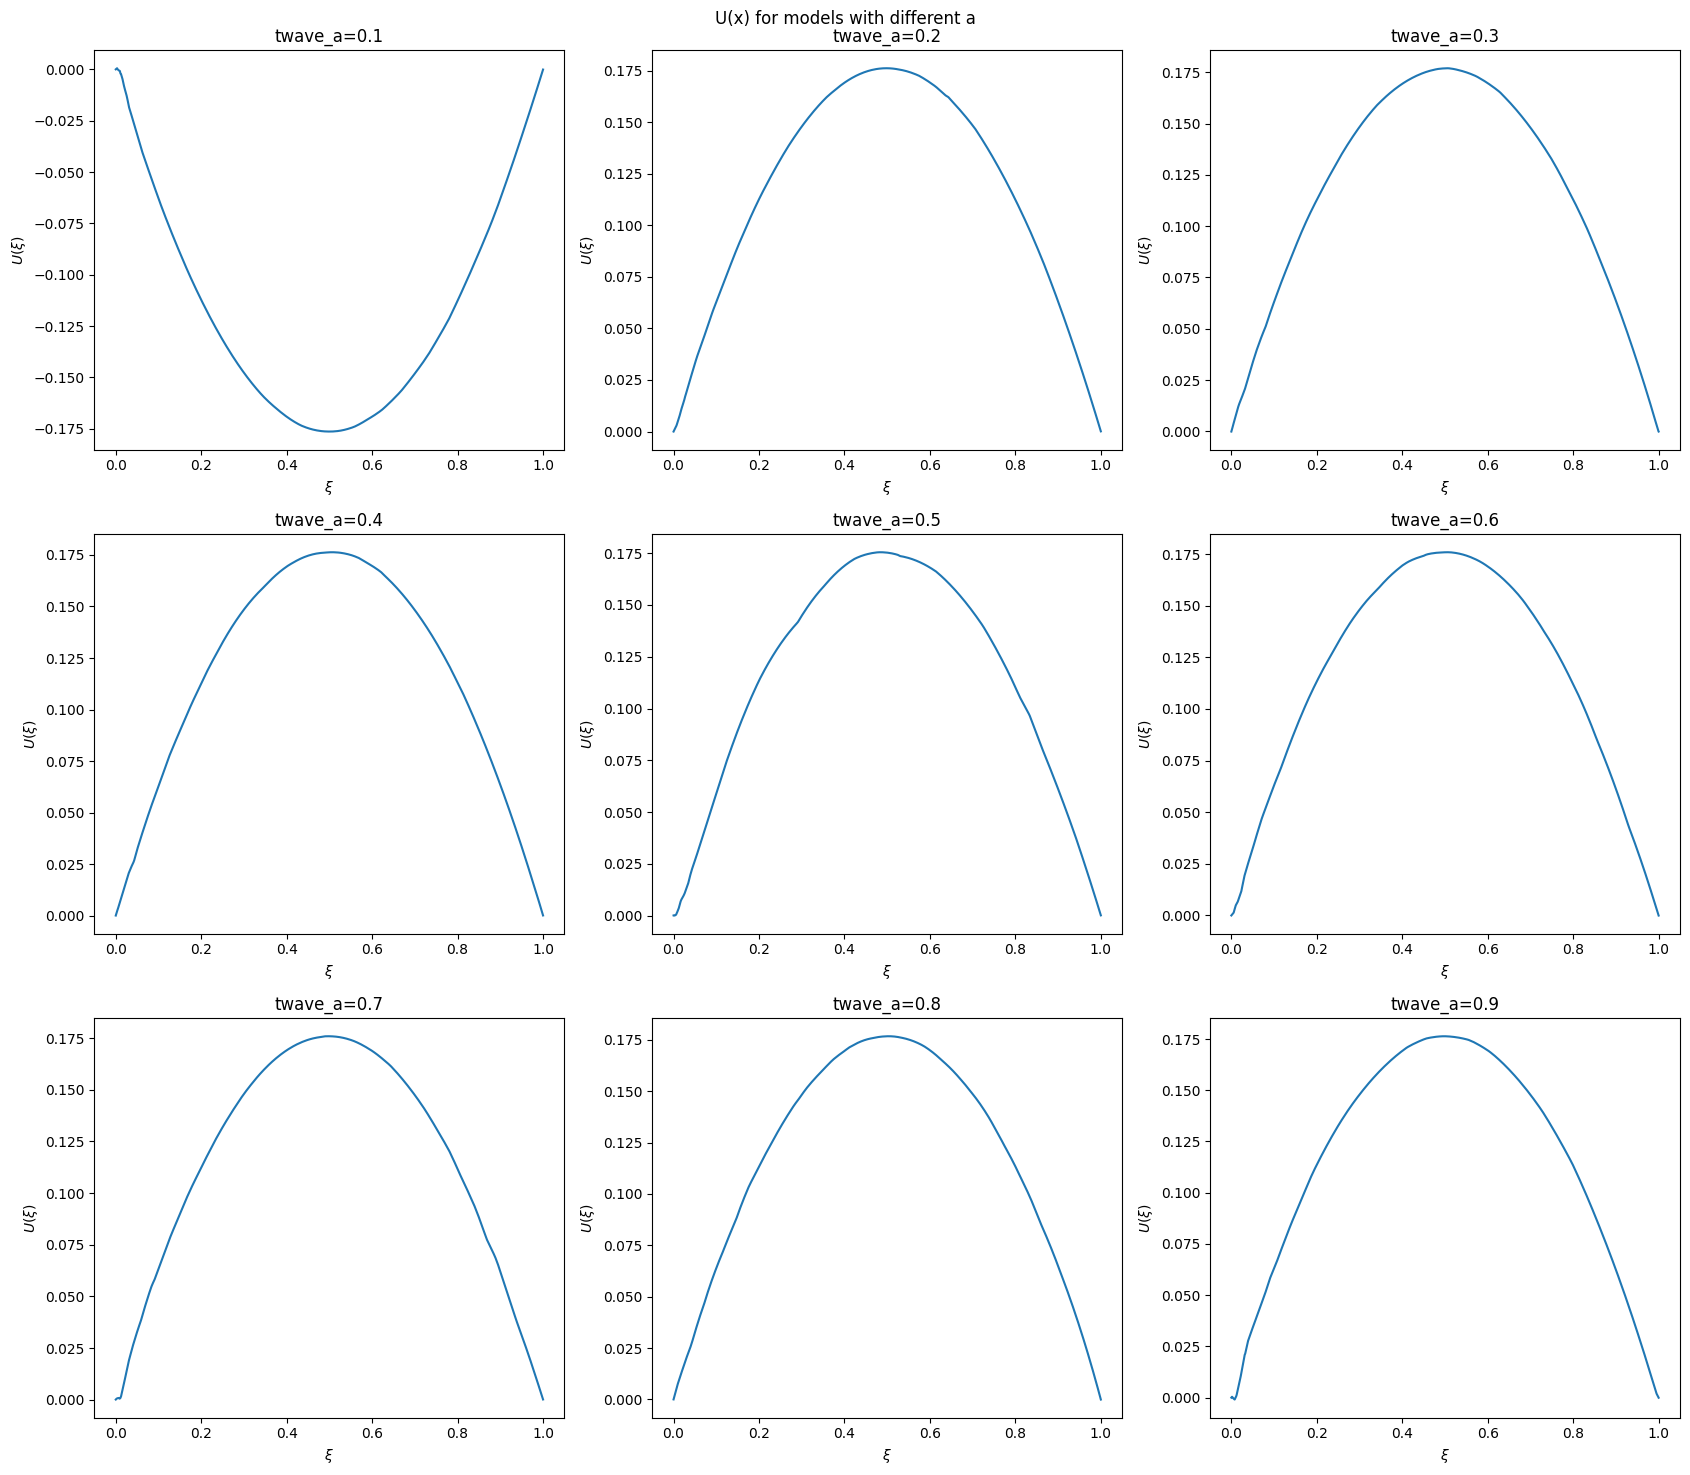

In [53]:
# Viewing saved models
from matplotlib import pyplot as plt

fig, axes = plt.subplots(3,3,figsize=(17,15))

# Determine predictions of u(x)
X = torch.tensor(np.linspace(xmin,xmax, 5000).reshape(-1,1), dtype=dtype).to(device)

for i in range(3):
    for j in range(3):
        ax = axes[i,j]

        # Load and Determine predictions of u(x)
        model = loadModel(f"../traveling_wave_models/{file_path[3*i+j]}")
        upred = model(X)

        # Plot results
        ax.plot(X.cpu().detach(),upred.cpu().detach())
        ax.set_title(f'{file_path[3*i+j]}')
        ax.set_xlabel(r'$\xi$')
        ax.set_ylabel(r'$U(\xi)$')

fig.suptitle("U(x) for models with different a")
plt.tight_layout()
plt.show()